Завдання: Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

# 1. Підготовка Данних

## 1.1 Зчитування та підрахунок

Зручніше всього буде провести частину розрахунків, пов'язаних з ЕDA, під час завантаження.

In [91]:
import pandas as pd
import numpy as np
from pathlib import Path

current_directory = Path.cwd()
target_directory = str(current_directory) + '\\accel\\data'
test_directory = str(current_directory) + '\\accel\\test'


def collect_data(folder: str):
    # Lists to store DataFrames and labels
    dfs = []
    labels = []
    
    # Quantities
    idle_r = 0
    running_r = 0
    walking_r = 0
    stairs_r = 0
    
    idle_q = 0
    running_q = 0
    walking_q = 0
    stairs_q = 0

    # Looping through
    for item in Path(folder).iterdir():
        labels.append(item.name) # creating category list
        
        if item.is_dir():
            for file in item.glob('*.csv'):
                
                df = pd.read_csv(file) #readfile
                df['category'] = item.name # add category
                
                # count
                match item.name: 
                    case 'idle':
                        idle_r += len(df)
                        idle_q += 1
                    case 'running':
                        running_r += len(df)
                        running_q += 1
                    case 'stairs':
                        stairs_r += len(df)
                        stairs_q += 1
                    case 'walking':
                        walking_r += len(df)
                        walking_q += 1
                
                # collect dfs
                dfs.append(df)
    
    # Quantity output
    print(f'\n For {folder}: \n')
    print(f'Files | I: {idle_q}, R: {running_q}, S: {stairs_q}, W: {walking_q}')
    print(f'Total files = {idle_q + running_q + stairs_q + walking_q} \n')
    print(f'Rows | I: {idle_r}, R: {running_r}, S: {stairs_r}, W: {walking_r}')
    print(f'Total rows = {idle_r + running_r + stairs_r + walking_r}')
    
    return dfs, labels


# Upload datasets
dfs, col_labels = collect_data(target_directory)
dfs_test, col_labels = collect_data(test_directory)

print('\n Done!')


 For C:\Users\Professional\goit_python\conda_t\accel\data: 

Files | I: 839, R: 2728, S: 132, W: 1480
Total files = 5179 

Rows | I: 25170, R: 81840, S: 3960, W: 44400
Total rows = 155370

 For C:\Users\Professional\goit_python\conda_t\accel\test: 

Files | I: 200, R: 680, S: 33, W: 370
Total files = 1283 

Rows | I: 6000, R: 20400, S: 990, W: 11100
Total rows = 38490

 Done!


## 1.2 EDA


### Кількість файлів:

Train part files:

- Idle - 839
- Running - 2728
- Stairs - 132
- Walking - 1480

- Total: 5179


Test part files:

- Idle - 200
- Running - 680
- Stairs - 33
- Walking - 370

- Total: 1283

### Баланс категорій:

Як можна побачити при завантаженні, кожна із категорій наявна у тренувальній та тестовій частині:

- Train:

1) Rows | I: 25170 (16,5%), R: 81840 (52,7%), S: 3960 (2,55%), W: 44400 (28,6%)
2) Total rows = 155370

- Test:

1) Rows | I: 6000 (15,6%), R: 20400 (53%), S: 990 (2,57%), W: 11100 (28,8%)
2) Total rows = 38490

Аналіз показує, що класи будуть дуже несбалансованими. Зокрема, можна очікувати найбільших помилок із передбаченням сходів (stairs) та простою (idle).

Баланси між класами збережені між тестувальною та тренувальною частинами.

### Зміст та типи даних:

Якщо подивитись всередину кожного СSV файлу, ми подачимо що вони являють собою часові ряди. Кількість строк (вимірів) по трьом осям акселерометра (accelerometer_X, accelerometer_Y, accelerometer_Z) - 30.

Також був доданий стовпчик з категорією для подальшої зручності обробки рядів.

Наступний датасет є прикладом одного із таких рядів.

In [40]:
# Check the result
dfs[0]

,accelerometer_X,accelerometer_Y,accelerometer_Z,category
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle
5,-0.086191,-0.148441,9.787497,idle
6,-0.062249,-0.191536,9.773131,idle
7,-0.057461,-0.114922,9.763555,idle
8,-0.124498,-0.162806,9.782708,idle
9,-0.138864,-0.124498,9.768343,idle


Також перевіримо список з категоріями:

In [41]:
col_labels

['idle', 'running', 'stairs', 'walking']

Всі категорії присутні.

Подивимось інфо про перший датасет та переконаємось, що кожен стовчик (крім категорії) - це float, а пусті значення не присутні.

In [46]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   accelerometer_X  30 non-null     float64
 1   accelerometer_Y  30 non-null     float64
 2   accelerometer_Z  30 non-null     float64
 3   category         30 non-null     object 
dtypes: float64(3), object(1)
memory usage: 1.1+ KB


Тепер перевіримо однорідність за допомогою скрипта:

In [88]:
# Types check
files_with_wrong_types = []
count_files_with_wrong_types = 0

for df in dfs:
    # types check
    df_types = df.dtypes
    if (df_types[0] != 'float64') or (df_types[1] != 'float64') or (df_types[2] != 'float64'):
        files_with_wrong_types.append(file.name)
        count_files_with_wrong_types += 1
        
# Types check output
print(f'\n Check for consistent types:')
if count_files_with_wrong_types != 0:
    print(f'Nulls: {count_files_with_wrong_types}')
    print(f'Files: {files_with_wrong_types}')
else:
    print('No files with wrong types! \n')


 Check for consistent types:
No files with wrong types! 



Скрипт підтверджує, що ми маємо 'float64' для кожної строчки (крім 'category') у кожному датафреймі. Тобно данні однорідні.

### Пусті, максимальні та мінімальні значення

Також перевіримо, щоб кожен датафрейм не мав пустих значень:

In [89]:
# File check
files_with_nulls = []
count_files_with_nulls = 0

for df in dfs:
    # file check
    df_nulls = df.isnull().sum()
    if (df_nulls[0] != 0) or (df_nulls[1] != 0) or (df_nulls[2] != 0) or (df_nulls[3] != 0):
        files_with_nulls.append(file.name)
        count_files_with_nulls += 1
        
# File check output
print(f'\n Check for nulls:')
if count_files_with_nulls != 0:
    print(f'Nulls: {count_files_with_nulls}')
    print(f'Files: {files_with_nulls}')
else:
    print('No files with nulls! \n')


 Check for nulls:
No files with nulls! 



Пусті значення не присутні. В кінці кінців, перевіримо які максимальні та мінімальні значення для перших трьох колонок, щоб провести нормалізацію та стандартизацію:

In [90]:
row_max_q = 0
row_min_q = 999
row_min_val = 0
row_max_val = 0

for df in dfs:
    
    # Check info
    ## max rows
    info = df.describe()

    if info.loc['count'][0] >= row_max_q: 
        row_max_q = info.loc['count'][0]
    elif info.loc['count'][1] >= row_max_q: 
        row_max_q = info.loc['count'][1]
    elif info.loc['count'][2] >= row_max_q:
        row_max_q = info.loc['count'][2]

    ## min rows

    if info.loc['count'][0] <= row_min_q: 
        row_min_q = info.loc['count'][0]
    elif info.loc['count'][1] <= row_min_q: 
        row_min_q = info.loc['count'][1]
    elif info.loc['count'][2] <= row_min_q:
        row_min_q = info.loc['count'][2]

    ## max value
    if info.loc['max'][0] >= row_max_val: 
        row_max_val = info.loc['max'][0]
    elif info.loc['max'][1] >= row_max_val: 
        row_max_val = info.loc['max'][1]
    elif info.loc['max'][2] >= row_max_val:
        row_max_val = info.loc['max'][2]

    ## min value
    if info.loc['min'][0] <= row_min_val: 
        row_min_val = info.loc['min'][0]
    elif info.loc['min'][1] <= row_min_val: 
        row_min_val = info.loc['min'][1]
    elif info.loc['min'][2] <= row_min_val:
        row_min_val = info.loc['min'][2]
        
# Description
print(f'Max rows quantity: {row_max_q}')
print(f'Min rows quantity: {row_min_q}')
print(f'Max value: {row_max_val}')
print(f'Min value: {row_min_val}')

Max rows quantity: 30.0
Min rows quantity: 30.0
Max value: 39.188293
Min value: -39.188293


Як бачимо, мінімальне та максимальне значення, на які був розрахований акселерометр: +-39.188293.

In [44]:
### temporary disabled, another procedure has been used

### collect into 1 big document
# data = pd.concat(dfs, ignore_index=True)
# print(data)
# data.info()
# labels = data['category'].unique()

## 1.3 Нормалізація та стандартизація

Так як нам буде незручно працювати із значенням +-39.188293 і воно може вплинути на передбачення, ми нормалізуємо данні, щоб кожне значення було не більше +-1.

In [96]:
## In order to achieve good results with SVM algo, we need to standardize(normalize) our data
## Let's try MaxAbsScaler worked by providing us with minimals -1 and maximals 1.

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, MaxAbsScaler

def normalize_data(data: pd.DataFrame):  
    numeric_columns_names = data.columns[:3] # Берем X,Y,Z
    scaler = MaxAbsScaler() # Видає ефективну нормалізацію

    normalized_data = scaler.fit_transform(data[numeric_columns_names]) # нормалізація

    normalized_df = pd.DataFrame(normalized_data, columns=numeric_columns_names) # Перетворбємо результат на датафрейм
    normalized_df = pd.concat([normalized_df, data[data.columns[-1]]], axis=1) # Приєднуємо колонку з категоріями
    
    return normalized_df


# Нормалізація
## Ініціалізація списків нормалізованих датафреймів
normalized_df=[]
normalized_df_test=[]

## Ініціалізація списку, що буде містити найменше та найвище значення задля перевірки нормалізації
min_list=[]
max_list=[]


# Луп по датафреймам
for document in dfs:
    normalized = normalize_data(document) # Нормалізація
    normalized_df.append(normalized) # Додаємо у список
    
    # Додаємо ДФ з мін та макс значенням по кожному стовпчику
    min_list.append(normalized.min())
    max_list.append(normalized.max())

    
# З'єднуємо по кажному стовпчику всі датафрейми у одну велику строку
concat_min = pd.concat(min_list, axis=1)
concat_max = pd.concat(max_list, axis=1)

# По кожній строці знаходимо найменше та найбільше у строці, тобто у всьому наборі данних
mean_min = (concat_min.iloc[0].min(), concat_min.iloc[1].min(), concat_min.iloc[2].min())
mean_max = (concat_max.iloc[0].max(), concat_max.iloc[1].max(), concat_max.iloc[2].max())

print('Трейнова частина:')
print("Мін значення після нормалізації (X, Y, Z):", mean_min)
print("Макс значення після нормалізації (X, Y, Z):", mean_max)

min_list_test=[]
max_list_test=[]

for document in dfs_test:
    normalized = normalize_data(document)
    normalized_df_test.append(normalized)
    
    min_list_test.append(normalized.min())
    max_list_test.append(normalized.max())
    
concat_min = pd.concat(min_list_test, axis=1)
concat_max = pd.concat(max_list_test, axis=1)

mean_min = (concat_min.iloc[0].min(), concat_min.iloc[1].min(), concat_min.iloc[2].min())
mean_max = (concat_max.iloc[0].max(), concat_max.iloc[1].max(), concat_max.iloc[2].max())

print('Тестова частина:')
print("Мін значення після нормалізації (X, Y, Z):", mean_min)
print("Макс значення після нормалізації (X, Y, Z):", mean_max)


Трейнова частина:
Мін значення після нормалізації (X, Y, Z): (-1.0, -1.0, -1.0)
Макс значення після нормалізації (X, Y, Z): (1.0, 1.0, 1.0)
Тестова частина:
Мін значення після нормалізації (X, Y, Z): (-1.0, -1.0, -1.0)
Макс значення після нормалізації (X, Y, Z): (1.0, 1.0, 1.0)


In [97]:
normalized_df[0]

,accelerometer_X,accelerometer_Y,accelerometer_Z,category
0,0.196244,1.000000,0.874512,idle
1,0.140845,0.911826,0.861328,idle
2,-0.178404,-0.061203,0.938477,idle
3,1.000000,0.032158,0.858399,idle
4,0.345540,-0.035270,0.943359,idle
5,-0.016901,-0.032158,0.998047,idle
6,-0.012207,-0.041494,0.996582,idle
7,-0.011268,-0.024896,0.995606,idle
8,-0.024413,-0.035270,0.997559,idle
9,-0.027230,-0.026971,0.996094,idle


## 1.4 Фільтрування

Застосування фільтрації не має ефекту, як зазначено у документі: https://drive.google.com/file/d/1-18YEmp0YjV3hN9iI8J1i_FWd55HFwOK/view

Отже, будь-яка фільтрація не має позитивного імпакту і застосовуватись не буде

# 2. Feature Engineering

Ми звісно можемо намагатись передбачити категорію по нашим показникам акселерометра по трьом вісям, проте більш ефективним буде згенерувати нові фіча на їх основі.

Згідно з вишезазначеним досліжденням, найефективнішими виявились наступні:

- Maximum Value x Time
- Minimum Value x Time
- Entropy x Time
- Interquartile Range x Time
- Maximum Value y Time
- Index of Minimum Value y Time
- Mean of absolute deviation y Time
- Median y Time
- Skewness y Time
- Standard deviation y Time
- Root mean square error y Time
- Skewness z Time
- Normalized value of FFT coefficients x Frequency
- Normalized value of FFT coefficients y Frequency
- Normalized value of FFT coefficients z Frequency

In [101]:
# Now let's extract features that are confirmed as most effective from the same research:

# Name Axis Domain
# Maximum Value x Time
# Minimum Value x Time
# Entropy x Time
# Interquartile Range x Time
# Maximum Value y Time
# Index of Minimum Value y Time
# Mean of absolute deviation y Time
# Median y Time
# Skewness y Time
# Standard deviation y Time
# Root mean square error y Time
# Skewness z Time
# Normalized value of FFT coefficients x Frequency
# Normalized value of FFT coefficients y Frequency
# Normalized value of FFT coefficients z Frequency

feature_labels = ['Maximum Value x Time',
          'Minimum Value x Time',
          'Entropy x Time',
          'Interquartile Range x Time',
          'Maximum Value y Time',
          'Index of Minimum Value y Time',
          'Mean of absolute deviation y Time',
          'Median y Time',
          'Skewness y Time',
          'Standard deviation y Time',
          'Root mean square error y Time',
          'Skewness z Time',
          'Normalized value of FFT coefficients x Frequency',
          'Normalized value of FFT coefficients y Frequency',
          'Normalized value of FFT coefficients z Frequency'
         ]

In [102]:
## Extracting features from time series

from scipy.stats import entropy, skew
from scipy.fftpack import fft
from scipy.signal import find_peaks

# Let's group our data by category
# grouped_data = normalized_df.groupby('category')

def extract_features(grouped_data: pd.DataFrame):
    features = []
    
#     print(grouped_data)
    
    ### Max X time
    feature_data = grouped_data['accelerometer_X'].max()
    features.append(feature_data)

    ### Min X time
    feature_data = grouped_data['accelerometer_X'].min()
    features.append(feature_data)
    
#     print(feature_data)

    ### Entropy X time
    feature_data = []
    bins = np.histogram(grouped_data['accelerometer_X'], bins='auto')[0]
    bins = bins + 1e-10 ## avoiding log()
    feature_data = entropy(bins, base=2, axis=0)

#     for category in grouped_data:
#         cat_name = category[0]
#         data = grouped_data.get_group(cat_name)
#         bins = np.histogram(data['accelerometer_X'], bins='auto')[0]
#         bins = bins + 1e-10 ## avoiding log()
#         entropy_value = entropy(bins, base=2, axis=0)
#         feature_data.append(entropy_value)
#     # Ваши данные
#     data = {'category': ['idle', 'running', 'stairs', 'walking'],
#             'accelerometer_X': feature_data}
#     # Создайте DataFrame из данных
#     df = pd.DataFrame(data)
#     # Установите 'category' в качестве индекса
#     df.set_index('category', inplace=True)
#     # Выберите нужную колонку ('accelerometer_X') как объект Series
#     feature_data = df['accelerometer_X']
#     features.append(feature_data)

#     print(feature_data)
    

    ### Interquantile spread X?
    def calculate_iqr(group):
        q1 = group.quantile(0.25)
        q3 = group.quantile(0.75)
        iqr = q3 - q1
        return iqr

    feature_data = calculate_iqr(grouped_data['accelerometer_X'])
    features.append(feature_data)
    
#     print(feature_data)

    ### MAX Y
    feature_data = grouped_data['accelerometer_Y'].max()
    features.append(feature_data)

    ### IDX of MIN Y
    feature_data = grouped_data['accelerometer_Y'].idxmin()
    features.append(feature_data)
    
#     print(feature_data)

    ### MAD of Y
    def do_mad(group):
        return np.mean(np.abs(group - np.median(group)))

    feature_data = do_mad(grouped_data['accelerometer_Y'])
    features.append(feature_data)
    
#     print(feature_data)

    ### Meadian of Y
    feature_data = grouped_data['accelerometer_Y'].median()
    features.append(feature_data)

    ### Skewness of Y
    feature_data = grouped_data['accelerometer_Y'].skew()
    features.append(feature_data)

    ### Standart deviation of Y
    feature_data = grouped_data['accelerometer_Y'].std()
    features.append(feature_data)
    
#     print(feature_data)

    ### Root mean square error of Y
    def do_root(group):
        return np.sqrt(np.mean(group**2))

    feature_data = do_root(grouped_data['accelerometer_Y'])
    features.append(feature_data)
    
#     print(feature_data)

    ### Skewness of Z
    feature_data = grouped_data['accelerometer_Z'].skew()
    features.append(feature_data)

    ## FREQUENCIES
    def do_fft(group):
        group = np.array(group)
        group = np.abs(fft(group))
        group = pd.Series(group)
        return group

    fft_values_x = do_fft(grouped_data['accelerometer_X'])
    fft_values_y = do_fft(grouped_data['accelerometer_Y'])
    fft_values_z = do_fft(grouped_data['accelerometer_Z'])

    ### Normalized FFTs

#     print(fft_values_x)

    norm_fft_values_x = fft_values_x / sum(fft_values_x)
    norm_fft_values_y = fft_values_y / sum(fft_values_y)
    norm_fft_values_z = fft_values_z / sum(fft_values_z)

#     print(norm_fft_values_y)

#     norm_fft_values_x = norm_fft_values_x.groupby('category').mean()
#     norm_fft_values_y = norm_fft_values_y.groupby('category').mean()
#     norm_fft_values_z = norm_fft_values_z.groupby('category').mean()

    norm_fft_values_x = norm_fft_values_x.mean()
    norm_fft_values_y = norm_fft_values_y.mean()
    norm_fft_values_z = norm_fft_values_z.mean()
    
#     print(norm_fft_values_y)
    
    features.append(norm_fft_values_x)
    features.append(norm_fft_values_y)
    features.append(norm_fft_values_z)
    
    features.append(grouped_data['category'][0])
    
    return features


# Генеруємо фічі для трейнового датасету
data_features=[]

for document in normalized_df:
    features = extract_features(document)
    data_features.append(features)
    
# print(data_features)

# Генеруємо фічі для тестового датасету
test_features=[]

for document in normalized_df_test:
    features = extract_features(document)
    test_features.append(features)
    
# print(test_features)
# print(features)
# print(type(features[0]))


У результаті обробки, кожен часовий ряд із 30 строк перетворився на 1 список із згенерованих фіч + категорії того часового ряду.

In [116]:
print(len(data_features))
print(len(test_features))

5179
1283


# 3. Тренування та порівняння моделей

У якості моделей було обрано RandomForestClassifier та SVC.

Під час тренування будемо застосовувати KFold кросс-валідацію.

Обрані метрики: точність, precision, recall, F1 за допомогою функції classification_report

## 3.1 Підбір гіперпараметрів

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


# Робимо копію для зручності та на крайній випадок
features_orig = data_features
features = copy.deepcopy(features_orig) 

features_df = pd.DataFrame(features) # Перетворюємо список зі списками із згенерованими фічами у датафрейми
y = features_df[14] # Беремо категорії
X = features_df.drop(14, axis=1) # Беремо фічі


# Примітивний спліт для подвійних тестів
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Парамтери для тестів
param_grid_rf = {'max_depth': [None, 30, 70, 120, 200],
             'n_estimators': [1, 15, 75, 100]}

param_grid_svc = {'C': [0.2, 0.5, 0.7, 1, 10, 50, 100, 200, 500, 1000, 2000],
             'kernel': ['linear', 'poly', 'sigmoid']}

# Моделі
rf_classifier = RandomForestClassifier()
svc_classifier = SVC()

# Створюємо підбір
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5)
grid_search_svc = GridSearchCV(estimator=svc_classifier, param_grid=param_grid_svc, cv=5)

# Навчаємо, шуваємо комбінації
grid_search_rf.fit(X_train, y_train)
grid_search_svc.fit(X_train, y_train)

# Виводимо найкращі параметри
print("Найкращі параметри:", grid_search_rf.best_params_)
print("Найкращі параметри:", grid_search_svc.best_params_)

# Оцінюємо вдруге
accuracy = grid_search_rf.best_estimator_.score(X_test, y_test)
print("Точність на тестовому наборі (RF):", accuracy)
accuracy = grid_search_svc.best_estimator_.score(X_test, y_test)
print("Точність на тестовому наборі (SVC):", accuracy)

Найкращі параметри: {'max_depth': 30, 'n_estimators': 100}
Найкращі параметри: {'C': 500, 'kernel': 'linear'}
Точність на тестовому наборі (RF): 0.9961389961389961
Точність на тестовому наборі (SVC): 0.9806949806949807


Отже, RandomForestClassifier виявився більш точним у загальному розумінні.

## 3.2 Тренування

In [137]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import copy

# By the research, we will set 10 folds (За досліжденням, встановимо 10 фолдів для кросс-валідації)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# kf = KFold(n_splits=10, shuffle=False)

predicted_labels = []
test_labels = pd.DataFrame()
predicted_labels_svc = []

# Моделі
model = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42)
svm_model = SVC(C=500, kernel='linear')

## for cross-validation and training
for train_index, test_index in kf.split(X):
    # Для кожного фолда, зберігаємо тренувальну та тестову частини
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Навчання
    model.fit(X_train, y_train)
    svm_model.fit(X_train, y_train)
    
    # Передбачення тестової частини
    y_pred = model.predict(X_test)
    svm_predictions = svm_model.predict(X_test)
    
    # Зберігаємо передбачені класи у список
    pred_labels = predicted_labels.extend(y_pred)
    pred_labels_svc = predicted_labels_svc.extend(svm_predictions)
    
    # Додаємо до списку справжні класи, отримані при розділені на фолди
    test_labels = pd.concat([test_labels, y_test], axis=0)

    
# print(y_test)
# print(predicted_labels)

# Отримуємо точність, порівнюючи тестові лейбли із передбаченними
accuracy_for = accuracy_score(test_labels, predicted_labels)
print(f'Accuracy Forest: {accuracy_for}')

accuracy_svc = accuracy_score(test_labels, predicted_labels_svc)
print(f'Accuracy SVC: {accuracy_svc}')
    

Accuracy Forest: 0.9969106005020274
Accuracy SVC: 0.9824290403552809


## 3.3 Оцінка якості моделей

In [141]:
from sklearn.metrics import classification_report

# Отображаемые имена классов
target_names = col_labels

# Получение отчета о классификации
report_rf = classification_report(test_labels, predicted_labels, target_names=target_names)
report_svc = classification_report(test_labels, predicted_labels_svc, target_names=target_names)


# Печать отчета
print(report_rf)
print(report_svc)

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       839
     running       1.00      1.00      1.00      2728
      stairs       0.98      0.93      0.95       132
     walking       0.99      1.00      1.00      1480

    accuracy                           1.00      5179
   macro avg       0.99      0.98      0.99      5179
weighted avg       1.00      1.00      1.00      5179

              precision    recall  f1-score   support

        idle       0.98      0.97      0.98       839
     running       0.99      1.00      0.99      2728
      stairs       0.82      0.73      0.77       132
     walking       0.98      0.99      0.98      1480

    accuracy                           0.98      5179
   macro avg       0.94      0.92      0.93      5179
weighted avg       0.98      0.98      0.98      5179



Отже, як і передбачалось, найбільш неточними виявились прогнози про перебування на сходах. Тим не менш, навіть для цього класу було досягнуто 93% по найгіршому показнику для моделі RFC - recall.

Детальне вивчення результатів від SVM показало, що вона гірша за RFC як в цілому, так і для окремих класів.

Висновок: навчена модель дуже ефективна завдяка вірно обробленим даним, згенерованим фічам, вірно підібраним гіперпараметрам та алгоритму.

## 4. Візуалізація

# 4.1 Зміна точності під час навчання

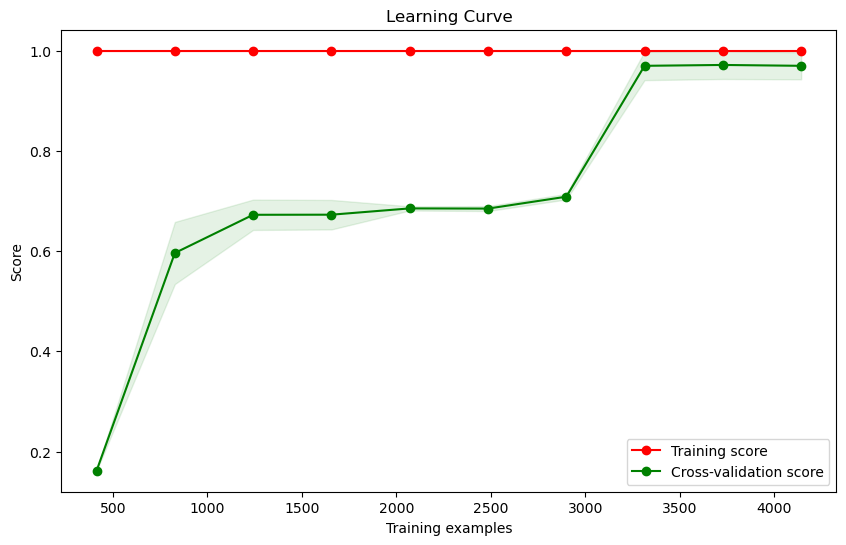

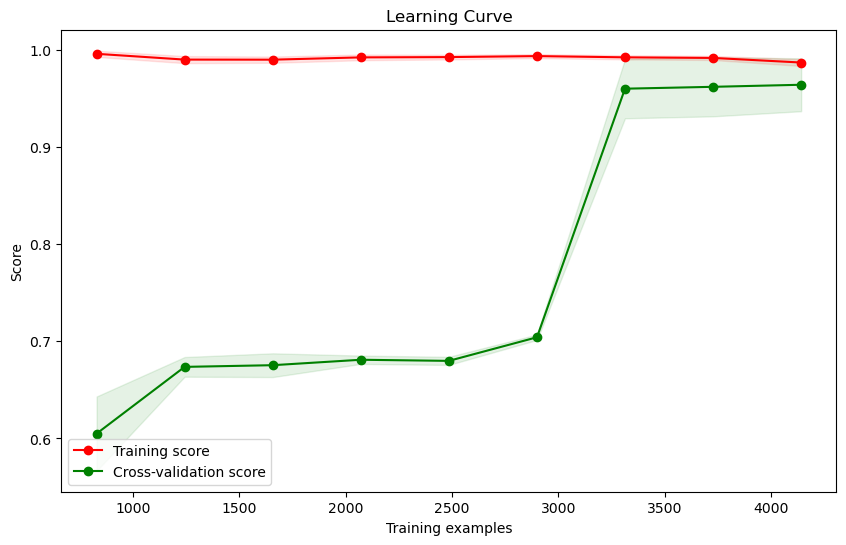

In [142]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Используйте вашу модель и данные
plot_learning_curve(model, X, y, cv=5)
plot_learning_curve(svm_model, X, y, cv=5)

In [ ]:
# For the Random Forest Classifier (graph at right), we can see that the training and test scores have not yet converged, so potentially this model would benefit from adding more training data (e.g. around 700–1000 training instances).

# 4.2 Візуалізація результату від гіперпараметрів

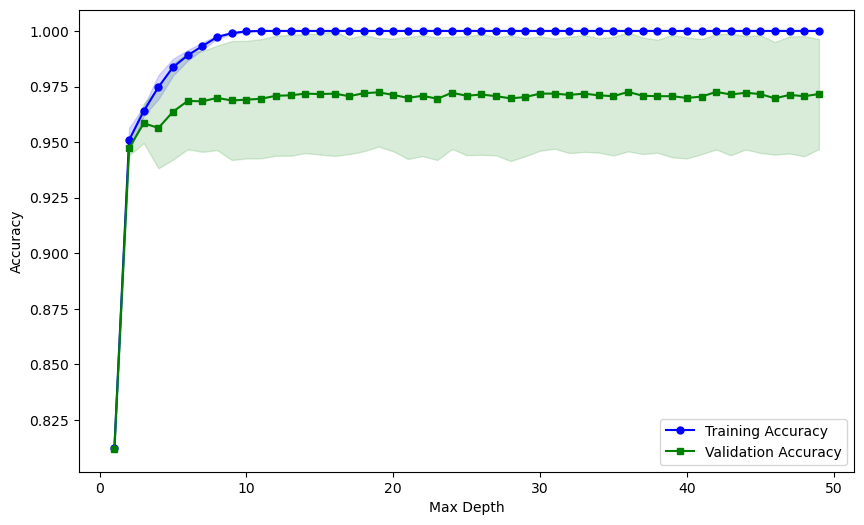

In [58]:
from sklearn.model_selection import validation_curve

model = RandomForestClassifier()

    # Определяем диапазон значений гиперпараметра, который хотим исследовать
param_range = np.arange(1, 50)

    # Используем validation_curve для создания графика
train_scores, test_scores = validation_curve(
        model, X, y, param_name="max_depth", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
        )

    # Вычисляем средние значения и стандартные отклонения
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Строим график
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="Training Accuracy")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, color="green", marker="s", markersize=5, label="Validation Accuracy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# # Используйте вашу модель, данные и параметры для проверки
# plot_validation_curve(model, X, y, param_name='accuracy', param_range=[0, 100], cv=5)
# plot_validation_curve(svm_model, X, y, param_name='accuracy', param_range=[0, 100], cv=5)


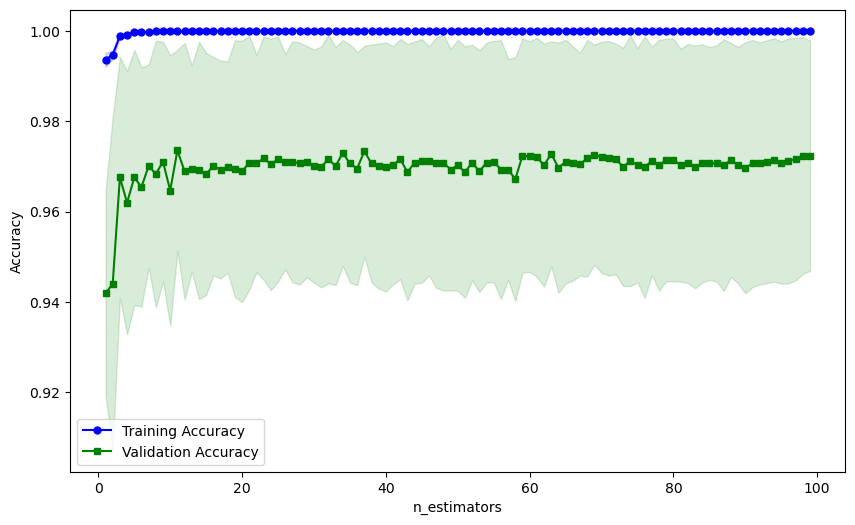

In [143]:
from sklearn.model_selection import validation_curve

model = RandomForestClassifier()

    # Определяем диапазон значений гиперпараметра, который хотим исследовать
param_range = np.arange(1, 100)

    # Используем validation_curve для создания графика
train_scores, test_scores = validation_curve(
        model, X, y, param_name="n_estimators", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
        )

    # Вычисляем средние значения и стандартные отклонения
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Строим график
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="Training Accuracy")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, color="green", marker="s", markersize=5, label="Validation Accuracy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

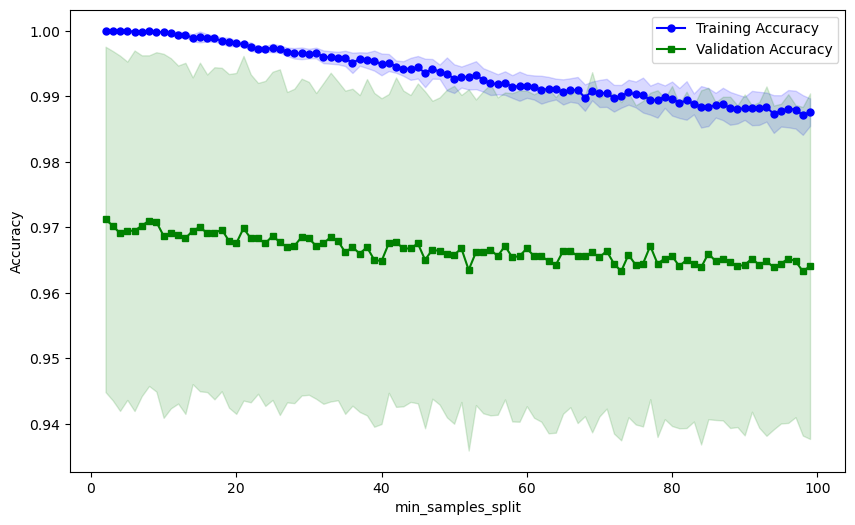

In [60]:
from sklearn.model_selection import validation_curve

model = RandomForestClassifier()

    # Определяем диапазон значений гиперпараметра, который хотим исследовать
param_range = np.arange(1, 100)

    # Используем validation_curve для создания графика
train_scores, test_scores = validation_curve(
        model, X, y, param_name="min_samples_split", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
        )

    # Вычисляем средние значения и стандартные отклонения
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Строим график
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="Training Accuracy")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, color="green", marker="s", markersize=5, label="Validation Accuracy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

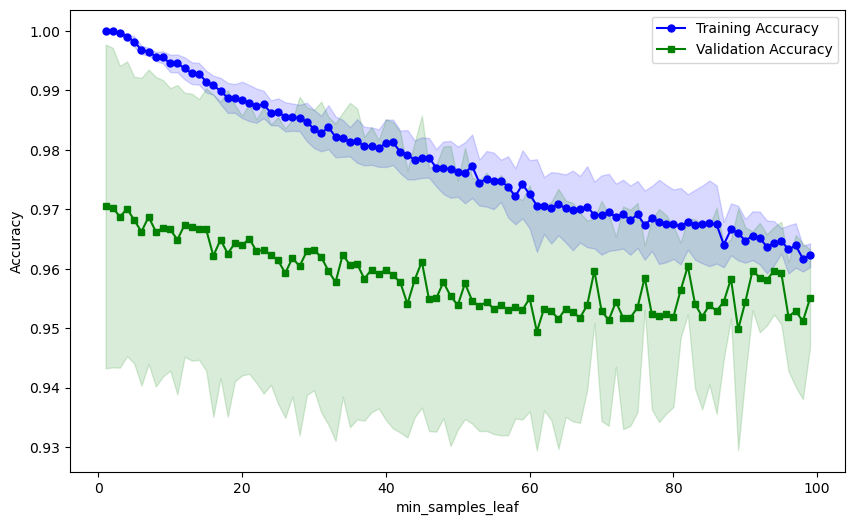

In [61]:
from sklearn.model_selection import validation_curve

model = RandomForestClassifier()

    # Определяем диапазон значений гиперпараметра, который хотим исследовать
param_range = np.arange(1, 100)

    # Используем validation_curve для создания графика
train_scores, test_scores = validation_curve(
        model, X, y, param_name="min_samples_leaf", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
        )

    # Вычисляем средние значения и стандартные отклонения
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Строим график
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="Training Accuracy")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, color="green", marker="s", markersize=5, label="Validation Accuracy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [130]:
## TESTING OTHER DATA SPLITTING METHODS

# feautures_orig: list
# test_features: list

# from sklearn.model_selection import train_test_split

# ### 2nd model
# print('This is a 2nd model')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Обучение модели
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# # Прогнозирование на тестовом наборе
# y_pred = model.predict(X_test)

# # Оценка производительности
# accuracy = accuracy_score(y_test, y_pred)

# print('Acc: ', accuracy)
# print('Pred: ', y_pred)
# print('y_test: ', y_test)

# #### 3rd model
# print('This is a 3rd model')

# second_data_train = [item for item in features_orig if item not in test_features]
# second_features_df = pd.DataFrame(second_data_train)
# second_test_df = pd.DataFrame(test_features)

# X_train = second_features_df.drop(14, axis=1)
# y_train = second_features_df[14]

# y_test = second_test_df[14]
# X_test = second_test_df.drop(14, axis=1)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)

# print('Acc: ', accuracy)
# print('Pred: ', y_pred)
# print('y_test: ', y_test)